In [1]:
import my_utils as mu
import torch
from torch import nn
import numpy as np

# Elliot Linsey Neural Network ECS659P QMUL (FASHION MNIST)

## Downloading Data

In [2]:
# Read training and test data
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
# type(train_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Importing the data and checking the shape

Each batch comes as a tensor of shape [256, 1, 28, 28]. For every 28x28 image we want to cut it into 4 patches. 

In [3]:
X,y = next(iter(train_iter))
print(X.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 1, 28, 28])


### Patching
To cut into patches, we use the .unfold() function on every batch, this creates a [256, 1, 2, 2, 14, 14] tensor. Our desired shape is [256,4,196]. That is, 256 images with 4 patches, each patch flattened to 196 pixels, per batch.

In [4]:
patches = X.unfold(2, 14, 14).unfold(3, 14, 14)
patches.shape

torch.Size([256, 1, 2, 2, 14, 14])

These two functions below work together to return a tensor of desired shape [256,4,196].
They flatten the patches, append them to a list then stack them into a tensor again. 

In [5]:
def tuple_of_tensors_to_tensor(tuple_of_tensors):
    return  torch.stack(list(tuple_of_tensors), dim=0)

In [6]:
X.shape
patches.shape
def patching(batch):
  final = []
  batch = batch.unfold(2, 14, 14).unfold(3, 14, 14)
  for x in batch:
    p = x.flatten()
    p = torch.split(p,196)
    p = tuple_of_tensors_to_tensor(p)
    p.shape
    final.append(p)
  final = torch.stack(final)
  return final

X2 = patching(X)
X2.shape

torch.Size([256, 4, 196])

## The Net

The input to the net is each batch of [256,4,196]. The stem contains the patching function, every batch that is fed into the net is patched first. From here, a linear layer is applied. 

The backbone contains 2 blocks, both containing 2 MLPs and two transpose functions.

A mean of all the features is taken, then fed into a Classifier with output 10 to match the number of class labels.

In [7]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.Linear1 = nn.Linear(num_inputs, 196)
        self.relu = nn.ReLU()
        self.Linear2 = nn.Linear(4, 20)
        self.Linear3 = nn.Linear(20, 10)
        self.Linear4 = nn.Linear(196, 100)
        self.Linear5 = nn.Linear(100, 50)
        self.Linear6 = nn.Linear(10,15)
        self.Linear7 = nn.Linear(15,4)
        self.Linear8 = nn.Linear(50, 25)
        self.Linear9 = nn.Linear(25, 25)
        self.Linear10 = nn.Linear(25,num_outputs)
    
    def tuple_of_tensors_to_tensor(self,tuple_of_tensors):
        return  torch.stack(list(tuple_of_tensors), dim=0) 
    
    def patching(self,batch):
        final = []
        batch = batch.unfold(2, 14, 14).unfold(3, 14, 14)
        for x in batch:
          p = x.flatten()
          p = torch.split(p,196)
          p = self.tuple_of_tensors_to_tensor(p)
          p.shape
          final.append(p)
        final = torch.stack(final)
        return final
    
    def forward(self, x):
        #STEM
        x = self.patching(x)
        #Results in shape [256,4,196] after patching
        out = self.Linear1(x)

        #FIRST BLOCK + FIRST MLP (before every MLP is a transpose function)
        out = torch.transpose(out,1,2)        
        out = self.Linear2(out)
        out = self.relu(out)
        out = self.Linear3(out)
        #SECOND MLP
        out = torch.transpose(out,1,2)
        out = self.Linear4(out)
        out = self.relu(out)
        out = self.Linear5(out)
        
        #SECOND BLOCK + THIRD MLP
        out = torch.transpose(out,1,2)
        out = self.Linear6(out)
        out = self.relu(out)
        out = self.Linear7(out)

        #FOURTH MLP
        out = torch.transpose(out,1,2)
        out = self.Linear8(out)
        out = self.relu(out)
        out = self.Linear9(out)

        #Taking the Mean of all features
        out = out.mean(axis=1)
        #Feeding to Classifier
        out = self.Linear10(out)
        #Outputs [256,10]
        return out

In [8]:
# Model instantiation and initialisation 
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [9]:
# Creating Model:
num_inputs, num_outputs = 196, 10
net = Net(num_inputs, num_outputs)

# Initialising weights
net.apply(init_weights)

Net(
  (Linear1): Linear(in_features=196, out_features=196, bias=True)
  (relu): ReLU()
  (Linear2): Linear(in_features=4, out_features=20, bias=True)
  (Linear3): Linear(in_features=20, out_features=10, bias=True)
  (Linear4): Linear(in_features=196, out_features=100, bias=True)
  (Linear5): Linear(in_features=100, out_features=50, bias=True)
  (Linear6): Linear(in_features=10, out_features=15, bias=True)
  (Linear7): Linear(in_features=15, out_features=4, bias=True)
  (Linear8): Linear(in_features=50, out_features=25, bias=True)
  (Linear9): Linear(in_features=25, out_features=25, bias=True)
  (Linear10): Linear(in_features=25, out_features=10, bias=True)
)

# Loss and Optimization Algorithm

In [10]:
# Using Cross Entropy loss:
loss = nn.CrossEntropyLoss()
lr, wd = 0.01, 0.0005
# Using ADAM optimizer
optimizer = torch.optim.Adam(net.parameters(),weight_decay=wd,lr=lr)

# Training

* Using the 'mu.trainf' function that I have put in my edited my_utils file, also in the submitted zip file. 

In [11]:
num_epochs = 20

loss 0.347, train acc 0.872, test acc 0.863
4253.7 examples/sec on cuda


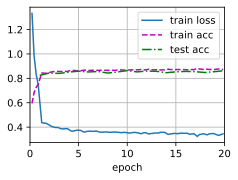

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
mu.trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

## Results
After 20 Epochs, we achieve a test accuracy of 0.863. This is close to the training accuracy of 0.872 so it does not appear that we have overfitted. The loss is 0.347. 

Hyperparameters used: 

Epochs: 20

Batch size: 256

Patch size: 14x14

Learning rate: 0.01

Weight decay: 0.0005

Optimizer: ADAM

Loss: Cross entropy loss

Weight initialisation: kaiming_normal_

Number of blocks: 2

Thanks for reading! 

Elliot Linsey 

QMUL

### References

All functions from my_utils were taken from the d2l course and website